In [84]:
import numpy as np
import pandas as pd
from plscan import PLSCAN
from hdbscan import HDBSCAN
from lib.plotting import *

configure_matplotlib()  # uses latex for text rendering!
data = np.load("data/clusterable/sources/clusterable_data.npy")

## PLSCAN

In [85]:
c = PLSCAN(min_samples=5).fit(data)

Layers

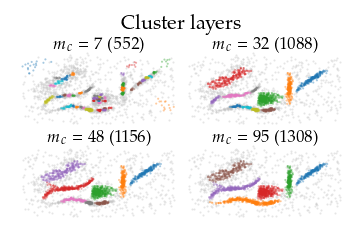

In [86]:
layers = c.cluster_layers(max_peaks=4)

sized_fig(0.32)
for i, (size, labels, probs) in enumerate(layers):
    plt.subplot(2, 2, i + 1)
    mask = labels > -1
    plt.scatter(*data[~mask].T, color='silver', s=1, alpha=0.4, linewidth=0)
    plt.scatter(*data[mask].T, c=labels[mask] % 10, s=1, alpha=0.4, linewidth=0, vmax=9, cmap="tab10")
    idx = np.searchsorted(c._persistence_trace.min_size, size)
    plt.title(
        f"$m_c={int(size)}$ ({c._persistence_trace.persistence[idx]:.0f})",
        fontsize=fontsize["footnote"],
        y=0.85,
    )
    plt.axis("off")
plt.suptitle("Cluster layers", y=1)
plt.subplots_adjust(left=0, right=1, top=0.83, bottom=0, wspace=0)
plt.savefig("images/plscan_cluster_layers.pdf", pad_inches=0)
plt.show()

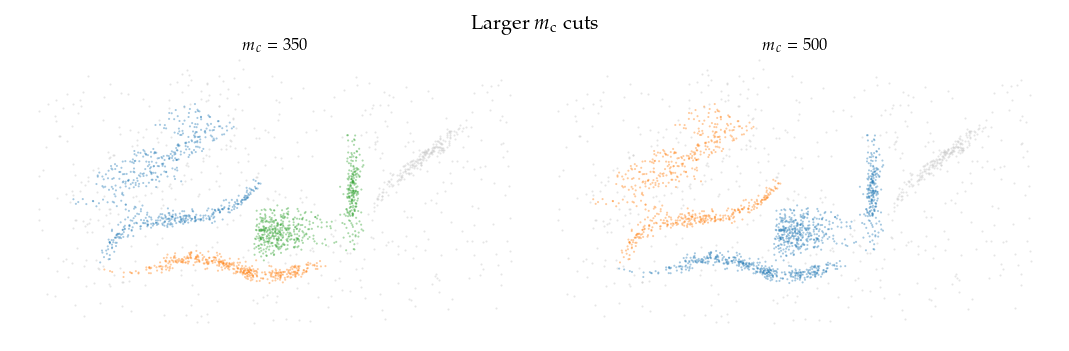

In [87]:
sized_fig(1, 0.618 / 2)
for i, mc in enumerate([350, 500]):
    plt.subplot(1, 2, i + 1)
    labels, probs = c.min_cluster_size_cut(mc)
    mask = labels != -1
    plt.scatter(*data[~mask].T, color='silver', s=1, alpha=0.4, linewidth=0)
    plt.scatter(*data[mask].T, c=labels[mask] % 10, s=1, alpha=0.4, linewidth=0, vmax=9, cmap="tab10")
    plt.title(
        f"$m_c={int(mc)}$",
        fontsize=fontsize["footnote"],
        y=0.95,
    )
    plt.axis("off")
plt.suptitle("Larger $m_{\\rm c}$ cuts", y=1)
plt.subplots_adjust(0, 0, 1, 0.9, 0, 0)
plt.savefig("images/plscan_larger_layers.pdf", pad_inches=0)
plt.show()

Leaf tree

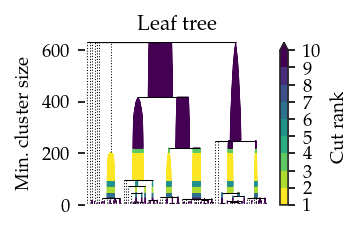

In [88]:
sized_fig(0.32)
c.leaf_tree_.plot(leaf_separation=0.05)
plt.title("Leaf tree")
plt.ylabel("Min.~cluster size")
plt.subplots_adjust(0.21, 0.06, 0.9, 0.85)
plt.savefig("images/plscan_leaf_tree.pdf", pad_inches=0)
plt.show()

Persistence trace

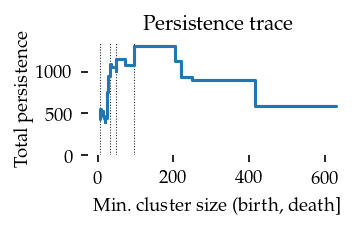

In [6]:
sized_fig(0.32)
for size, _, _ in layers:
    plt.axvline(size, color="k", lw=0.5, ls=":", alpha=1)
c.persistence_trace_.plot()
plt.title("Persistence trace")
plt.ylabel("Total persistence", labelpad=1)
plt.xlabel("Min.~cluster size (birth, death]")
plt.subplots_adjust(0.22, 0.3, 1, 0.85)
plt.savefig("images/plscan_persistence_trace.pdf", pad_inches=0)
plt.show()

Parameter sensitivity

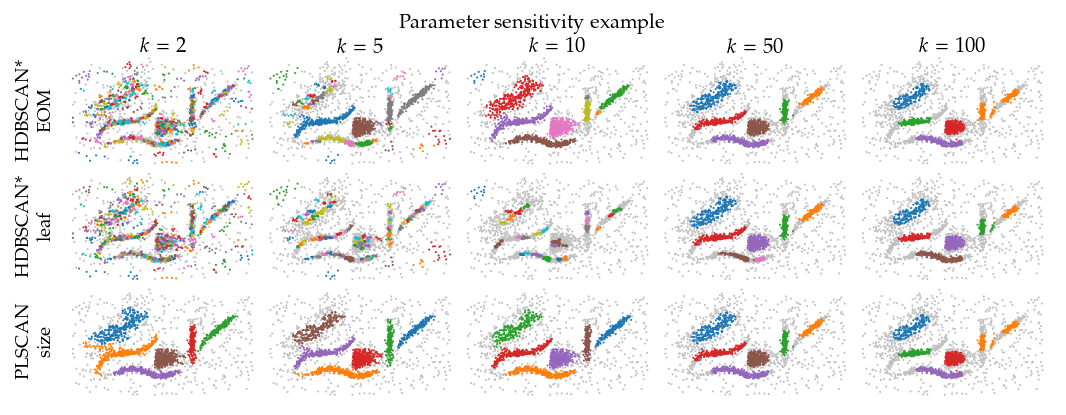

In [7]:
sized_fig(1, 0.618 / 5 * 3)
count = 1
for j, (alg, kwargs, name) in enumerate(
    [
        (HDBSCAN, {}, "HDBSCAN*\nEOM"),
        (HDBSCAN, {"cluster_selection_method": "leaf"}, "HDBSCAN*\nleaf"),
        (PLSCAN, {}, "PLSCAN\nsize"),
    ]
):
    for i, size in enumerate([2, 5, 10, 50, 100]):
        c = alg(min_samples=size, min_cluster_size=size, **kwargs).fit(data)
        plt.subplot(3, 5, count)
        count += 1
        plot_kwargs = dict(s=1, cmap="tab10", vmax=9, vmin=0, edgecolors="none")
        mask = c.labels_ == -1
        plt.scatter(*data[mask].T, color="silver", s=1, edgecolors="none")
        plt.scatter(*data[~mask].T, c=c.labels_[~mask] % 10, **plot_kwargs)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(name)
        if j == 0:
            plt.title(f"$k={size}$", y=0.9)
plt.suptitle("Parameter sensitivity example", y=1)
plt.subplots_adjust(0.05, 0, 1, 0.9, hspace=0, wspace=0)
plt.savefig("images/plscan_parameter_example.pdf", pad_inches=0)
plt.show()

Modelled probability density profile

In [8]:
def pdf_order(tree, current_node, bonus=None):
    children = tree.child[tree.parent == current_node]
    if bonus is not None:
        children = np.concatenate([bonus, children])
    if len(children) == 0:
        return [current_node]
    else:
        sorted_children = np.concatenate([children[0::2], children[1::2][::-1]])
        return sum([pdf_order(tree, child) for child in sorted_children], [])

In [9]:
def density_plot(tree, N, c):
    density_plot_order = np.array(
        pdf_order(tree, N + 1, np.flatnonzero(tree.parent == N))
    )
    density_values = np.empty(density_plot_order.shape[0])
    for idx, i in enumerate(density_plot_order):
        density_values[idx] = np.exp(-100 * tree.distance[tree.child == i][0])
    plt.gca().fill_between(np.arange(density_values.shape[0]), density_values, color=c)

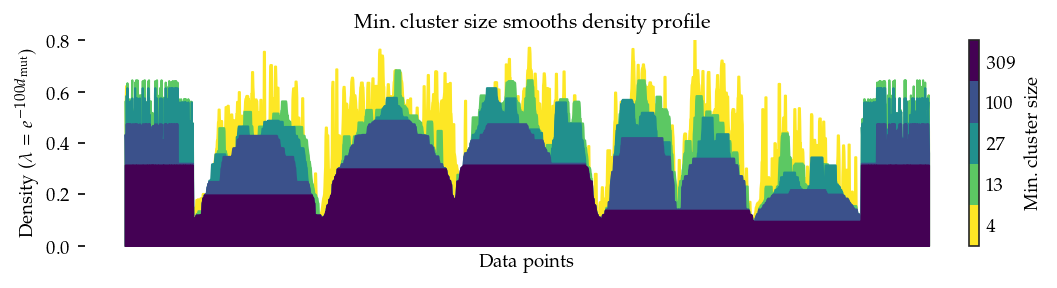

In [10]:
sized_fig(1, 0.25)
mcs = [4, 13, 27, 100, 309]
palette = plt.cm.viridis_r.resampled(len(mcs))
for i, mc in enumerate(mcs):
    c2 = PLSCAN(min_samples=2, min_cluster_size=int(mc)).fit(data)
    density_plot(c2._condensed_tree, data.shape[0], palette.colors[i])
plt.ylim(0, 0.8)
plt.xticks([])
plt.ylabel("Density ($\\lambda = e^{-100 d_{\\rm mut}})$")
plt.xlabel("Data points")
plt.suptitle("Min.~cluster size smooths density profile", y=1)
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(0, len(mcs)), cmap=palette),
    ax=plt.gca(),
    label="Min.~cluster size",
    ticks=[i + 0.5 for i in range(len(mcs))],
    pad=0,
)
cb.ax.tick_params(length=0)
cb.set_ticklabels([str(int(mc)) for mc in mcs])
plt.subplots_adjust(0.07, 0.11, 1.07, 0.9, hspace=0, wspace=0)
plt.savefig("images/plscan_density_smoothing.pdf", pad_inches=0)
plt.show()

## Leaf tree explainer

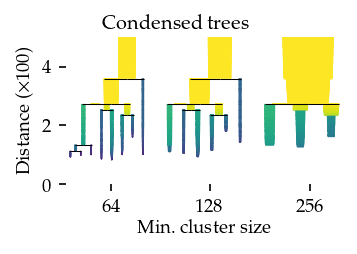

In [90]:
sized_fig(0.32, 0.68)

yticks = [0, 0.02, 0.04]
symbol = "m_{\\rm c}"
mcs = [64, 128, 256]
for i, mc in enumerate(mcs):
    plt.subplot(1, 3, i + 1)
    c3 = PLSCAN(min_samples=5, min_cluster_size=mc).fit(data)
    c3.condensed_tree_.plot(colorbar=False, leaf_separation=1)
    plt.ylim(0, 0.05)
    if i == 0:
        plt.ylabel("Distance ($\\times 100$)")
        plt.yticks(yticks)
        plt.gca().set_yticklabels([f"${int(y*100)}$" for y in yticks])
    else:
        plt.ylabel("")
        plt.yticks([])
    plt.xticks(np.diff(plt.xlim()) / 2)
    plt.gca().set_xticklabels([f"${mc}$"])
plt.text(
    (1 - 0.17) / 2 + 0.17,
    0.05,
    f"Min.~cluster size",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gcf().transFigure,
    fontsize=fontsize["small"],
)
plt.suptitle("Condensed trees", y=1)
plt.subplots_adjust(0.17, 0.25, 1, 0.9)
plt.savefig("images/plscan_condensed_trees.pdf", pad_inches=0)
plt.show()

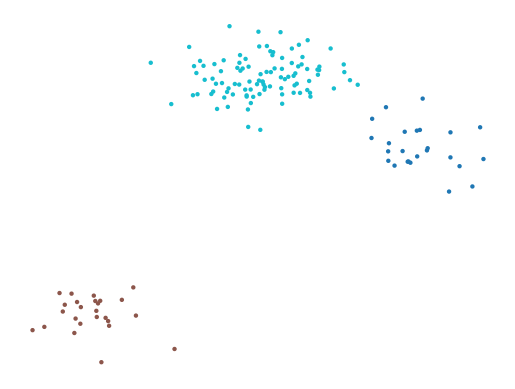

In [3]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(50, centers=2, random_state=1)
X2, y2 = make_blobs(100, centers=1, random_state=5)
X = np.vstack((X1, X2))
y = np.hstack((y1, y2 + y1.max() + 1))

c = PLSCAN(min_samples=10).fit(X)
plt.scatter(*X.T, c=y, s=10, cmap="tab10", edgecolors="none")
plt.axis("off")
plt.show()

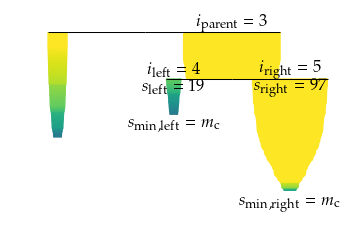

In [7]:
sized_fig(0.32)
leaf_separation = 3
t = c.condensed_tree_
sizes = c._condensed_tree.child_size[c._condensed_tree.cluster_rows]
xcoords = t._x_coords(t._leaf_tree.parent) * leaf_separation
t.plot(y="density", leaf_separation=leaf_separation, colorbar=False)
plt.yticks([])
plt.ylabel("")
plt.ylim(0.6, None)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.max_distance[3]),
    r"$i_{\rm parent} = 3$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[4],
    np.exp(-t._leaf_tree.max_distance[4]),
    r"$i_{\rm left} = 4$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[5],
    np.exp(-t._leaf_tree.max_distance[5]),
    r"$i_{\rm right} = 5$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[4],
    np.exp(-t._leaf_tree.min_distance[4]),
    r"$s_{\rm min,left} = m_{\rm c}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[5],
    np.exp(-t._leaf_tree.min_distance[5]),
    r"$s_{\rm min,right} = m_{\rm c}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[4],
    np.exp(-t._leaf_tree.max_distance[4]),
    r"$s_{\rm left} = " + f"{sizes[2]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[5],
    np.exp(-t._leaf_tree.max_distance[5]),
    r"$s_{\rm right} = " + f"{sizes[3]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.subplots_adjust(0.01, 0.13, 0.99, 0.9)
plt.savefig("images/leaf_tree_explainer_1.pdf", pad_inches=0)
plt.show()

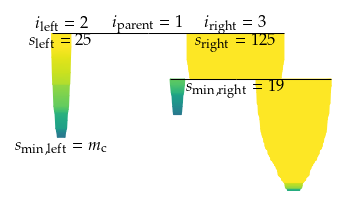

In [6]:
sized_fig(0.32)
t.plot(y="density", leaf_separation=leaf_separation, colorbar=False)
plt.yticks([])
plt.ylabel("")
plt.ylim(0.6, None)
plt.text(
    xcoords[1],
    np.exp(-t._leaf_tree.max_distance[1]),
    r"$i_{\rm parent} = 1$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[2],
    np.exp(-t._leaf_tree.max_distance[2]),
    r"$i_{\rm left} = 2$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.max_distance[3]),
    r"$i_{\rm right} = 3$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[2],
    np.exp(-t._leaf_tree.min_distance[2]),
    r"$s_{\rm min,left} = m_{\rm c}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.min_distance[3]),
    r"$s_{\rm min,right} = 19$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[2],
    np.exp(-t._leaf_tree.max_distance[2]),
    r"$s_{\rm left} = " + f"{sizes[0]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.max_distance[3]),
    r"$s_{\rm right} = " + f"{sizes[1]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.subplots_adjust(0.01, 0.13, 0.99, 0.9)
plt.savefig("images/leaf_tree_explainer_2.pdf", pad_inches=0)
plt.show()

In [92]:
for r in c._condensed_tree.cluster_rows:
  print(c._condensed_tree.parent[r] - X.shape[0], c._condensed_tree.child[r] - X.shape[0], c._condensed_tree.child_size[r], c._condensed_tree.distance[r])

1 2 25.0 8.137202
1 3 125.0 8.137202
3 4 19.0 1.7380712
3 5 97.0 1.7380712


In [97]:
for parent, min_dist, max_dist, min_size, max_size in zip(*c._leaf_tree):
    print(parent, min_dist, max_dist, min_size, max_size)

0 0.0 8.137202 25.0 150.0
0 8.137202 8.137202 25.0 25.0
1 0.92471606 8.137202 10.0 25.0
1 1.7380712 8.137202 19.0 25.0
3 1.1693937 1.7380712 10.0 19.0
3 0.48353362 1.7380712 10.0 19.0


## HDBSCAN

In [17]:
from sklearn.metrics import pairwise_distances

min_points = 5
distance_matrix = pairwise_distances(data)
np.fill_diagonal(distance_matrix, np.nan)
neighbors = np.argpartition(distance_matrix, min_points - 1)[:, :min_points]
core_distances = np.take_along_axis(distance_matrix, neighbors[:, -1][None], axis=0)[0]
density = 1 / core_distances

clusterer = HDBSCAN(min_samples=5, min_cluster_size=25).fit(data)

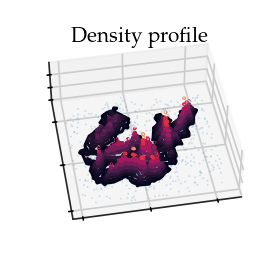

In [ ]:
import matplotlib.tri as mtri

fig = sized_fig(0.245, aspect=0.8)
tri = mtri.Triangulation(data[:, 0], data[:, 1])
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-100)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(density.min(), data.shape[0]),
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(tri, density, levels=np.exp(np.linspace(np.log(30), np.log(density.max()), 10)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(3, 3, 1))
plt.title("Density profile", y=0.9)
plt.subplots_adjust(-.1, -.1, 1.1, 1.05)
plt.savefig("./images/density_profile.pdf", pad_inches=0)
plt.show()

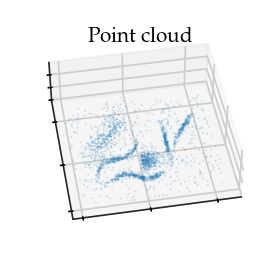

In [ ]:
fig = sized_fig(0.245, aspect=0.8)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-100)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(density.min(), data.shape[0]),
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(3, 3, 1))
plt.title("Point cloud", y=0.9)
plt.subplots_adjust(-.1, -.1, 1.1, 1.05)
plt.savefig("./images/density_profile_data.pdf", pad_inches=0)
plt.show()

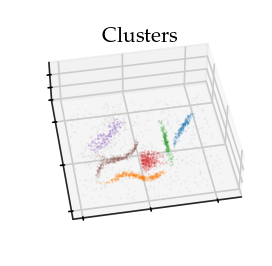

In [ ]:
fig = sized_fig(0.245, aspect=0.8)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-100)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(density.min(), data.shape[0]),
    c=["silver" if l < 0 else f"C{l}" for l in clusterer.labels_],
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(3, 3, 1))
plt.title("Clusters", y=0.9)
plt.subplots_adjust(-.1, -.1, 1.1, 1.05)
plt.savefig("./images/density_profile_clustered.pdf", pad_inches=0)
plt.show()

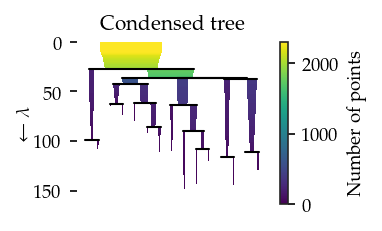

In [ ]:
sized_fig(0.25, aspect=0.8)
clusterer.condensed_tree_.plot(leaf_separation=0.2, label_clusters=False)
plt.yticks([0, 50, 100, 150])
plt.ylabel(r"$\leftarrow\lambda$", labelpad=0)
plt.title("Condensed tree")
plt.subplots_adjust(0.25, 0.05, 1.17, 0.83, 0, 0)
plt.savefig("./images/density_profile_hierarchy.pdf", pad_inches=0)
plt.show()